# T<sub>2</sub> Ramsey Characterization

The purpose of the $T_2$Ramsey experiment is to determine two of the qubit's properties: *Ramsey* or *detuning frequency* and $T_2^\ast$. The rough frequency of the qubit was already determined previously. The control pulses are based on this frequency. 

In this experiment, we would like to get a more precise estimate of the qubit's frequency. The difference between the frequency used for the control rotation pulses, and the precise frequency is called the *detuning frequency*. This part of the experiment is called a *Ramsey Experiment*. $T_2^\ast$ represents the rate of decay toward a mixed state, when the qubit is initialized to the $\left|1\right\rangle$ state.

Since the detuning frequency is relatively small, we add a phase gate to the circuit to enable better measurement. The actual frequency measured is the sum of the detuning frequency and the user induced *oscillation frequency* (`osc_freq` parameter).

In [1]:
import numpy as np
import qiskit
from qiskit_experiments.library import T2Ramsey

The circuit used for the experiment comprises the following:

    1. Hadamard gate
    2. delay
    3. RZ gate that rotates the qubit in the x-y plane 
    4. Hadamard gate
    5. measurement

The user provides as input a series of delays (in seconds) and the oscillation frequency (in Hz). During the delay, we expect the qubit to precess about the z-axis. If the p gate and the precession offset each other perfectly, then the qubit will arrive at the $\left|0\right\rangle$ state (after the second Hadamard gate). By varying the extension of the delays, we get a series of oscillations of the qubit state between the $\left|0\right\rangle$ and $\left|1\right\rangle$ states. We can draw the graph of the resulting function, and can analytically extract the desired values.

In [2]:
qubit = 0
# set the desired delays
delays = list(np.arange(1e-6, 50e-6, 2e-6))

In [3]:
# Create a T2Ramsey experiment. Print the first circuit as an example
exp1 = T2Ramsey(qubit, delays, osc_freq=1e5)

print(exp1.circuits()[0])

     ┌───┐┌─────────────────┐┌─────────┐ ░ ┌───┐ ░ ┌─┐
  q: ┤ H ├┤ Delay(1e-06[s]) ├┤ Rz(π/5) ├─░─┤ H ├─░─┤M├
     └───┘└─────────────────┘└─────────┘ ░ └───┘ ░ └╥┘
c: 1/═══════════════════════════════════════════════╩═
                                                    0 


We run the experiment on a simulated backend using Qiskit Aer with a pure T1/T2 relaxation noise model.

In [4]:
# A T1 simulator
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel

# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakeVigo(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakeVigo(), noise_model=noise_model)

The resulting graph will have the form:
$f(t) = a^{-t/T_2*} \cdot \cos(2 \pi f t + \phi) + b$
where *t* is the delay, $T_2^\ast$ is the decay factor, and *f* is the detuning frequency.

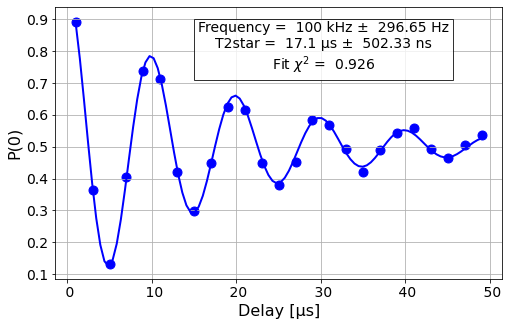

In [5]:
# Set scheduling method so circuit is scheduled for delay noise simulation
exp1.set_transpile_options(scheduling_method='asap')

# Run experiment
expdata1 = exp1.run(backend=backend, shots=2000)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

In [6]:
# Print results
for result in expdata1.analysis_results():
    print(result)

DbAnalysisResultV1
- name: @Parameters_T2RamseyAnalysis
- value: [5.03134860e-01 5.02597401e-01 1.71473845e-05 1.00031407e+05
 2.77773587e-03] ± [8.56574628e-03 2.16121293e-03 5.02334105e-07 2.96648807e+02
 2.12591111e-02]
- χ²: 0.9260210774124799
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: Frequency
- value: 100031.40725354789 ± 296.64880729562884 Hz
- χ²: 0.9260210774124799
- quality: good
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T2star
- value: 1.7147384521156154e-05 ± 5.023341049256533e-07 s
- χ²: 0.9260210774124799
- quality: good
- device_components: ['Q0']
- verified: False


### Providing initial user estimates
The user can provide initial estimates for the parameters to help the analysis process. Because the curve is expected to decay toward $0.5$, the natural choice for parameters $A$ and $B$ is $0.5$. Varying the value of $\phi$ will shift the graph along the x-axis. Since this is not of interest to us, we can safely initialize $\phi$ to 0. In this experiment, `t2ramsey` and `f` are the parameters of interest. Good estimates for them are values computed in previous experiments on this qubit or a similar values computed for other qubits.

/home/merav/work/t_phi/qiskit_experiments/curve_analysis/guess.py:188: RuntimeWarning: invalid value encountered in log
  coeffs = np.polyfit(x, np.log(y), deg=1)
/home/merav/work/t_phi/qiskit_experiments/curve_analysis/curve_analysis.py:865: UserWarning: All initial guesses and parameter boundaries failed to fit the data. Please provide better initial guesses or fit parameter boundaries.
  warnings.warn(


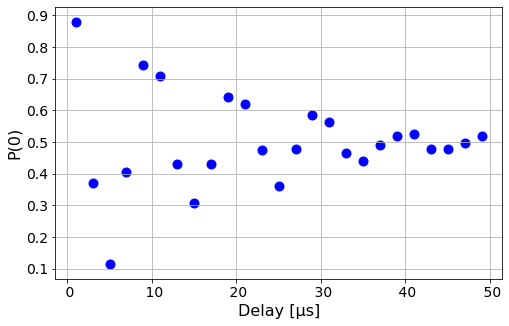

In [7]:
user_p0={
    "A": 0.5,
    "T2star": 20e-6,
    "f": 110000,
    "phi": 0,
    "B": 0.5
        }
exp_with_p0 = T2Ramsey(qubit, delays, osc_freq=1e5)
exp_with_p0.analysis.set_options(p0=user_p0)
exp_with_p0.set_transpile_options(scheduling_method='asap')
expdata_with_p0 = exp_with_p0.run(backend=backend, shots=2000)
expdata_with_p0.block_for_results()

# Display fit figure
display(expdata_with_p0.figure(0))

In [8]:
# Print results
for result in expdata_with_p0.analysis_results():
    print(result)

In [9]:
import qiskit.tools.jupyter
%qiskit_copyright